In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_score, f1_score, precision_score, recall_score
from skimage.metrics import structural_similarity as ssim
from sklearn import preprocessing
from keras.utils import to_categorical
from keras import regularizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Lambda, GlobalAveragePooling2D
from keras.src.legacy.preprocessing.image import ImageDataGenerator

import random
import re
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import gc

2025-05-01 20:29:21.797346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 20:29:21.808576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 20:29:21.811915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 20:29:21.820548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {gpus}")
else:
    print("Nenhuma GPU encontrada.")

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1746142176.051269    1644 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746142176.597637    1644 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746142176.597790    1644 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
imgs_path = 'AES_decrypt_spectrum_metrics'

TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1

SIMILARITY = 0.75

EPOCHS = 200
BATCH_SIZE = 32
RANDOM_STATE = 53

HIGH_FREQ_THRESHOLD = 1

output_dir = f"Results/Turnstile_loader results ({HIGH_FREQ_THRESHOLD}%)/"
os.makedirs(output_dir, exist_ok=True)

In [4]:
def get_next_filename(output_folder, base_name, type):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_index = 0
    
    while True:
        output_filename = f"{base_name}_{image_index}.{type}"
        output_path = os.path.join(output_folder, output_filename)
        
        if not os.path.exists(output_path):
            return output_filename
            
        image_index += 1

In [5]:
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0

In [6]:
def sort_files_numerically(file_paths):
    return sorted(file_paths, key=lambda x: extract_number(x))

In [7]:
def read_dataset(path, jpg, png):
    print(f'Reading dataset...\n')
    
    img_type = []
    images = []
    image_paths = []

    if jpg:
        img_type.append('*.jpg')
    if png:
        img_type.append('*.png')

    print(f'Reading images from: {path}')
    
    for img_type_pattern in img_type:
        img_paths = glob.glob(os.path.join(path, img_type_pattern))
        img_paths = sort_files_numerically(img_paths)
        
        for img_path in img_paths:
            img = cv2.imread(img_path, 0)
            images.append(img)
            image_paths.append(img_path)

    images = np.array(images)
    image_paths = np.array(image_paths)

    return images, image_paths

In [8]:
all_X, all_image_paths = read_dataset(path=imgs_path, jpg=True, png=True)

Reading dataset...

Reading images from: AES_decrypt_spectrum_metrics


In [9]:
def noise(image, threshold, add_noise, fshift):
    if add_noise:
        amplification_factor = 0.5
        rows, cols = image.shape
        crow, ccol = rows//2, cols//2

        corner = np.random.randint(0, 4)
        
        mask = np.zeros((rows, cols), dtype=bool)
        
        if corner == 0:    # Canto superior esquerdo
            mask[:crow - threshold, :ccol - threshold] = True
        elif corner == 1:  # Canto superior direito
            mask[:crow - threshold, ccol + threshold:] = True
        elif corner == 2:  # Canto inferior esquerdo
            mask[crow + threshold:, :ccol - threshold] = True
        else:              # Canto inferior direito
            mask[crow + threshold:, ccol + threshold:] = True

        fshift[mask] *= amplification_factor

    magnitude_spectrum_high = 20 * np.log(np.abs(fshift) + 1)

    return magnitude_spectrum_high

In [10]:
all_specs = []
all_labels = []

input_dir = "DATASET_dicom_fourier_spectrum"
file_list = sorted(os.listdir(input_dir))

for i, img in enumerate(all_X):
    filename = file_list[i]
    fshift = np.load(os.path.join(input_dir, filename))
    
    all_specs.append(noise(img, 100 - HIGH_FREQ_THRESHOLD, add_noise=False, fshift=fshift))
    all_labels.append(0)

for i, img in enumerate(all_X):
    filename = file_list[i]
    fshift = np.load(os.path.join(input_dir, filename))
    
    all_specs.append(noise(img, 100 - HIGH_FREQ_THRESHOLD, add_noise=True, fshift=fshift))
    all_labels.append(1)

all_specs = np.array(all_specs)
all_labels = np.array(all_labels)

In [11]:
print("Quantidade das imagens:", all_specs.shape)
print("Exemplo dos labels (False = original, True = com ruído):", all_labels)

Quantidade das imagens: (164, 512, 512)
Exemplo dos labels (False = original, True = com ruído): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
X_train, X_test, y_train, y_test, = train_test_split(
        all_specs, all_labels,
        test_size=TEST_SIZE, 
        stratify=all_labels,
#       random_state=RANDOM_STATE
    )

In [13]:
def plot_specs(specs, title):
    total_images = len(specs)
    imgs_per_figure = 100
    cols = 5
    rows = (imgs_per_figure + cols - 1) // cols

    for start in range(0, total_images, imgs_per_figure):
        plt.figure(figsize=(cols * 3, rows * 3))
        end = min(start + imgs_per_figure, total_images)
        
        for i in range(start, end):
            plt.subplot(rows, cols, i - start + 1)
            plt.imshow(specs[i], cmap='gray')
            plt.title(f"{title} - freq spec: img {i+1}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

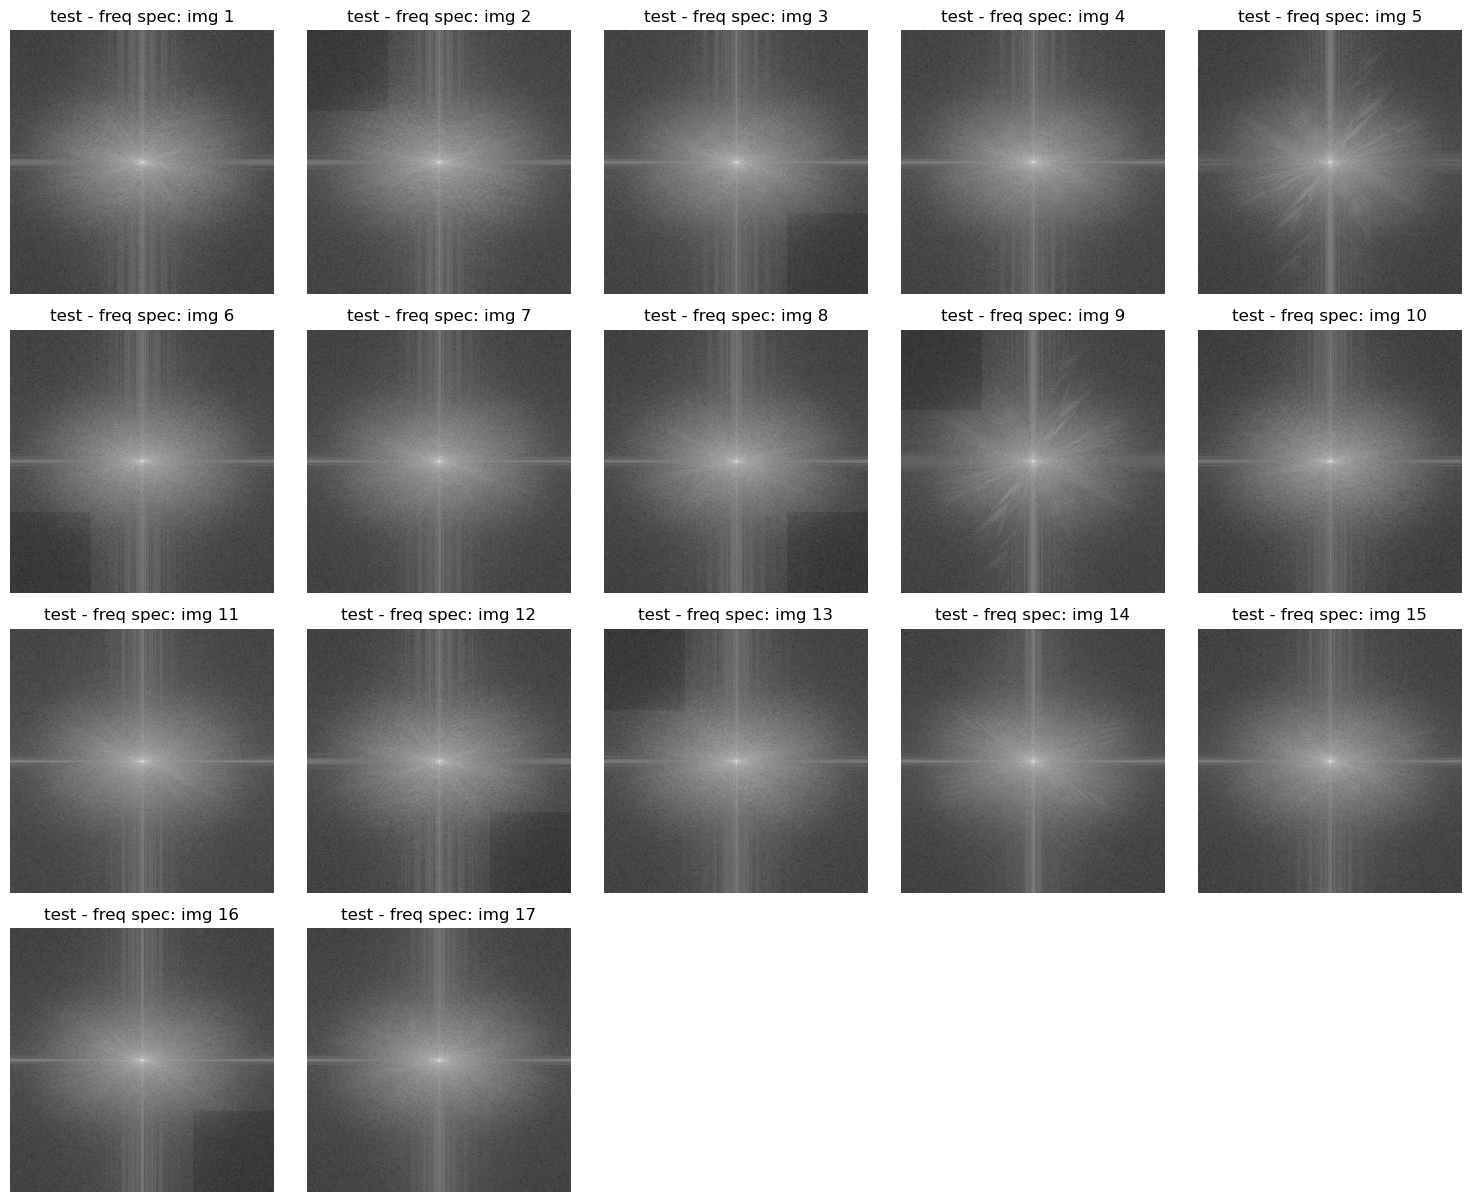

In [14]:
# Plotar todos os espectros de teste
#plot_specs(X_test, title="test")

In [15]:
#pausa de teste

In [16]:
# Defines the model layers (now for ResNet50)
def model_resnet50():  # (Optional: Rename the function for clarity)
    # Camada de entrada para imagens em escala de cinza (mantido igual)
    inputs = Input(shape=(512, 512, 1))

    # 1. Conversão para 3 canais (mantido igual)
    x = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # 2. Pré-processamento ResNet (mantido igual)
    x = tf.keras.applications.resnet.preprocess_input(x)

    # 3. *** ALTERAÇÃO PRINCIPAL: Carregar ResNet-50 ***
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )

    # 4. Topo personalizado (mantido igual)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(150, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
    x = Dropout(0.25)(x)

    x = Dense(100, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)
    x = Dropout(0.25)(x)

    outputs = Dense(2, activation='softmax')(x)

    # Compilação (mantido igual)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Configurar K-Fold com random_state fixo para reprodutibilidade
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Verificar quais folds já foram completados
completed_folds = []
for f in range(1, 6):
    model_path = output_dir + f'model_fold_{f}.keras'
    if os.path.exists(model_path):
        completed_folds.append(f)
print(f"Folds concluídos: {completed_folds}")

fold_no = 1
histories = []
metrics = []

for train_idx, val_idx in kfold.split(X_train, y_train):
    # Pular folds já concluídos
    if fold_no in completed_folds:
        print(f"\nPulando fold {fold_no} (já concluído)")
        fold_no += 1
        continue

    print(f'\nTreinando Fold {fold_no}/5')
    
    # Split dos dados
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]

    # Pré-processamento final
    X_train_fold = np.expand_dims(X_train_fold, axis=-1)
    X_val_fold = np.expand_dims(X_val_fold, axis=-1)
    y_train_fold_cat = to_categorical(y_train_fold, 2)
    y_val_fold_cat = to_categorical(y_val_fold, 2)

    # Criar novo modelo para cada fold
    model = model_resnet50()

    # Checkpoint com nome do fold
    checkpoint_filepath = output_dir + f'model_fold_{fold_no}.keras'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    # Calcula tempo (start)
    start_time = time.time()
    
    # Treinar modelo
    history = model.fit(
        X_train_fold, y_train_fold_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val_fold, y_val_fold_cat),
        callbacks=callbacks,
        verbose=1
    )

    # Calcula tempo (end)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"\nO modelo demorou {training_time:.2f} segundos para treinar.")

    # Coletar métricas e salvar modelo
    predictions = model.predict(X_val_fold)
    y_pred = np.argmax(predictions, axis=1)
    
    metrics.append({
        'fold': fold_no,
        'report': classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0),
        'matrix': confusion_matrix(y_val_fold, y_pred)
    })

    # Métricas de classificação (por fold)
    acc.append(accuracy_score(y_val_fold, y_pred))
    jacc.append(jaccard_score(y_val_fold, y_pred))
    f1.append(f1_score(y_val_fold, y_pred))
    prec.append(precision_score(y_val_fold, y_pred))
    rec.append(recall_score(y_val_fold, y_pred))

    # Salvar métricas em um arquivo .txt
    metrics_filename = os.path.join(output_dir, f'metrics_fold_{fold_no}.txt')
    with open(metrics_filename, 'w') as f:
        f.write(f"Fold {fold_no} Metrics:\n")
        f.write(f"Accuracy: {acc[-1]}\n")
        f.write(f"Jaccard Score: {jacc[-1]}\n")
        f.write(f"F1 Score: {f1[-1]}\n")
        f.write(f"Precision: {prec[-1]}\n")
        f.write(f"Recall: {rec[-1]}\n")
        f.write("\nClassification Report:\n")
        f.write(classification_report(y_val_fold, y_pred, zero_division=0))
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(confusion_matrix(y_val_fold, y_pred)))

    # Limpeza de memória
    del model
    tf.keras.backend.clear_session()
    gc.collect()

    # Salvar checkpoint a cada 3 folds
    if fold_no % 3 == 0:
        print(f"\nCheckpoint: Folds {fold_no-2}-{fold_no} concluídos")

    fold_no += 1

Folds concluídos: []

Treinando Fold 1/5
Epoch 1/200


I0000 00:00:1746142266.341484    1704 service.cc:146] XLA service 0x7f78ec005fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746142266.341591    1704 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-01 20:31:07.445734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-01 20:31:10.845683: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-05-01 20:31:15.289187: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15557', 196 bytes spill stores, 196 bytes spill loads

2025-05-01 20:31:33.501377: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng26{k2=0,k13=2,k14=3,k18=0,k22=0,k23=0} for conv (f

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5052 - loss: 4.7478

2025-05-01 20:32:21.833507: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15557', 208 bytes spill stores, 208 bytes spill loads

2025-05-01 20:32:43.852291: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng58{k2=1,k12=8,k13=0,k14=3,k15=1,k17=9,k18=1,k23=0} for conv (f32[128,256,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,256,128,128]{3,2,1,0}, f32[21,128,64,64]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-01 20:32:43.865292: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.919172058s
Trying algo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5178 - loss: 4.7441  

2025-05-01 20:33:07.698833: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1750', 208 bytes spill stores, 208 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Results/CNN-espectro-ResNet50 results (1%)/model_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 157s 22s/step - accuracy: 0.5253 - loss: 4.7419 - val_accuracy: 0.5000 - val_loss: 43.3655
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3913 - loss: 4.5204
Epoch 2: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step - accuracy: 0.3916 - loss: 4.5037 - val_accuracy: 0.5000 - val_loss: 161.4425
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4947 - loss: 4.0365
Epoch 3: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step - accuracy: 0.4915 - loss: 4.0248 - val_accuracy: 0.5000 - val_loss: 896.1136
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.5949 - loss: 3.6673
Epoch 4: val_accuracy did not improve from 0.50000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.5956 - loss: 3.6502 - val_accuracy: 0.5000 - val_loss: 10

2025-05-01 20:37:18.470898: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4B (rounded to 256)requested by op 
2025-05-01 20:37:18.471051: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-05-01 20:37:18.471085: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 777, Chunks in use: 777. 194.2KiB allocated for chunks. 194.2KiB in use in bin. 50.2KiB client-requested in use in bin.
2025-05-01 20:37:18.471093: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 233, Chunks in use: 233. 118.5KiB allocated for chunks. 118.5KiB in use in bin. 116.3KiB client-requested in use in bin.
2025-05-01 20:37:18.471099: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 443, Chunks in use: 443. 446.0KiB allocated for chunks. 446.0KiB in use in bin. 441.2KiB client-requested in use in bin.
202

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1644/3431839957.py", line 65, in <module>

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 4 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  305.23MiB
              constant allocation:       148B
        maybe_live_out allocation:  273.23MiB
     preallocated temp allocation:    8.52GiB
  preallocated temp fragmentation:   64.02MiB (0.73%)
                 total allocation:    8.82GiB
              total fragmentation:  133.49MiB (1.48%)
Peak buffers:
	Buffer 1:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block3_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,256,128,128]
		==========================

	Buffer 2:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block2_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,256,128,128]
		==========================

	Buffer 3:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block1_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,256,128,128]
		==========================

	Buffer 4:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block1_0_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,256,128,128]
		==========================

	Buffer 5:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv1_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 6:
		Size: 512.00MiB
		Operator: op_type="Relu" op_name="functional_1/conv2_block2_out_1/Relu" deduplicated_name="loop_maximum_fusion"
		XLA Label: fusion
		Shape: f32[32,256,128,128]
		==========================

	Buffer 7:
		Size: 256.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv3_block4_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,512,64,64]
		==========================

	Buffer 8:
		Size: 256.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv3_block3_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,512,64,64]
		==========================

	Buffer 9:
		Size: 256.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv3_block2_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,512,64,64]
		==========================

	Buffer 10:
		Size: 256.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv3_block1_0_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,512,64,64]
		==========================

	Buffer 11:
		Size: 256.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv3_block1_3_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,512,64,64]
		==========================

	Buffer 12:
		Size: 256.00MiB
		Operator: op_type="Relu" op_name="functional_1/conv3_block4_out_1/Relu" deduplicated_name="loop_maximum_fusion.2"
		XLA Label: fusion
		Shape: f32[32,512,64,64]
		==========================

	Buffer 13:
		Size: 256.00MiB
		Operator: op_type="Relu" op_name="functional_1/conv3_block2_out_1/Relu" deduplicated_name="loop_maximum_fusion.2"
		XLA Label: fusion
		Shape: f32[32,512,64,64]
		==========================

	Buffer 14:
		Size: 128.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block3_1_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,64,128,128]
		==========================

	Buffer 15:
		Size: 128.00MiB
		Operator: op_type="Conv2D" op_name="functional_1/conv2_block2_2_conv_1/convolution" source_file="/home/user/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,64,128,128]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_163896]

In [ ]:
print("Accuracy: "+ str(np.mean(acc)) + "+- " + str(np.std(acc)))
print("Jaccard: "+ str(np.mean(jacc)) + "+- " + str(np.std(jacc)))
print("Dice: "+ str(np.mean(f1)) + "+- " + str(np.std(f1)))
print("Precision: "+ str(np.mean(prec)) + "+- " + str(np.std(prec)))
print("Recall: "+ str(np.mean(rec)) + "+- " + str(np.std(rec)))

In [ ]:
# GC collect
tf.keras.backend.clear_session()
gc.collect()